<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/NLP/DZ_4_QA_using_bert_xlm_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question answering. Практическое задание (PJ)

Для закрепления материала модуля предлагаем вам решить задачу QA для датасета [SberQuad](https://huggingface.co/datasets/sberquad), используя любые доступные вам средства.

Для достижения наилучшего результата уделите внимание подбору гиперапарметров как в плане архитектуры, так и в плане обучения модели.

Критерии оценивания проекта:

- общее качество кода и следование PEP-8;
- использование рекуррентных сетей;
- использованы варианты архитектур, близкие к state of the art для данной задачи;
- произведен подбор гиперпараметров;
- использованы техники изменения learning rate (lr scheduler);
- использована адекватная задаче функция потерь;
- использованы техники регуляризации;
- корректно проведена валидация модели;
- использованы техники ensemble;
- использованы дополнительные данные;
- итоговое значение метрики качества > 0.75 (f1).


#PIP

In [1]:
!pip install transformers -q
!pip install datasets -q
!pip install evaluate -q
!pip install accelerate -U -q
!pip install transformers[torch] -q
exit() #restart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.4 MB/s eta 0:00:00


# Load_dataset

In [1]:
from datasets import load_dataset

raw_datasets = load_dataset("sberquad")
raw_datasets

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45328 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5036 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/23936 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 45328
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5036
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 23936
    })
})

In [2]:
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

Context:  В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.
Question:  чем представлены органические остатки?
Answer:  {'text': ['известковыми выделениями сине-зелёных водорослей'], 'answer_start': [109]}


In [3]:
raw_datasets["train"]["context"][0]

'В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.'

In [4]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"])

Телескоп имеет модульную структуру и содержит пять отсеков для оптических приборов. Один из отсеков в течение долгого времени (1993—2009 годы) занимала корректирующая оптическая система (COSTAR), установленная во время первой экспедиции обслуживания в 1993 году для компенсации неточности изготовления главного зеркала. Поскольку все приборы, установленные после запуска телескопа, имеют встроенные системы коррекции дефекта, во время последней экспедиции стало возможно демонтировать систему COSTAR и использовать отсек для установки ультрафиолетового спектрографа.
Как называется корректирующая оптическая система, установленная на телескоп во время первой экспедиции обслуживания в 1993 году для компенсации неточности изготовления главного зеркала?


# Tokenizer

In [36]:
from transformers import AutoTokenizer

trained_checkpoint ="AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru" # "timpal0l/mdeberta-v3-base-squad2" #
#trained_checkpoint = "timpal0l/mdeberta-v3-base-squad2" # "AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru" #
tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
tokenizer.is_fast

True

In [6]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'<s> чем представлены органические остатки?</s></s> В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.</s>'

In [7]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

<s> чем представлены органические остатки?</s></s> В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества</s>
<s> чем представлены органические остатки?</s></s>лей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли</s>
<s> чем представлены органические остатки?</s></s>скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие сов

# Take rand_part datasets

In [8]:
i =  2167
raw_datasets["validation"][i] , raw_datasets["test"][i]

({'id': 76422,
  'title': 'SberChallenge',
  'context': 'Относительно вхождения уральской семьи языков в более крупные генетические объединения существуют разные гипотезы, ни одна из которых не признана специалистами по уральским языкам. Согласно ностратической гипотезе, уральская семья, наряду с другими языковыми семьями и макросемьями входит в состав более крупного образования — ностратической макросемьи, причём сближается там с юкагирскими языками, образуя уральско-юкагирскую группу. Данная позиция, однако, была подвергнута критике различными специалистами, считается весьма спорной и её выводы не принимаются многими компаративистами, которые рассматривают теорию ностратических языков либо как, в худшем случае, полностью ошибочную или как, в лучшем случае, просто неубедительную[8][9]. Примерно до середины 1950-х гг. была популярна урало-алтайская гипотеза, объединявшая в одну макросемью уральские и алтайские языки, однако в настоящее время она не пользуется поддержкой лингвистов. С у

**В тесте нет ответов, поэтому тест делаем из val**

In [31]:
import numpy as np
part_of_data = 0.3

set_ids = np.random.choice(range(len(raw_datasets["validation"])), int(len(raw_datasets["validation"])*part_of_data*2.2), replace=False)
len(set_ids)

3323

In [32]:
choice = np.random.choice(range(len(set_ids)), int(len(set_ids)*0.2), replace=False)
test_mask = np.zeros(set_ids.shape[0], dtype=bool)
test_mask[choice] = True

test_ids = set_ids[test_mask]
val_ids = set_ids[~test_mask]
len(val_ids), len(test_ids)

(2659, 664)

In [33]:
from datasets import Dataset, DatasetDict

DATASETS = DatasetDict({
    'train': raw_datasets["train"].select(
            np.random.choice(range(len(raw_datasets["train"])), int(len(raw_datasets["train"])*part_of_data), replace=False)
        ),
    'validation': raw_datasets["validation"].select(val_ids
        ),
    'test': raw_datasets["validation"].select(test_ids
        )
})

DATASETS

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 13598
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 2659
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 664
    })
})

In [12]:
DATASETS["validation"][10],  DATASETS["validation"][10]['context'][60:]

({'id': 81905,
  'title': 'SberChallenge',
  'context': 'В 2015 году Федеральная налоговая служба РФ (ФНС РФ) запустила новую аналитическую систему АСК НДС-2, которая в автоматическом режиме вычисляет неплательщиков НДС. АСК НДС-2 исследует цепочки транзакций между юридическими лицами, с целью выявления так называемых фирм-однодневок , использующихся для уклонения от уплаты налогов, обналички. При обнаружении подобных схем, автоматически блокируются расчетные счета связанных компаний, и они рискуют получить внеплановую проверку со стороны ФНС РФ. Для минимизации налоговых рисков ФНС РФ рекомендует проявлять Должную осмотрительность при работе с контрагентом.',
  'question': 'В каком году Федеральная налоговая служба РФ (ФНС РФ) запустила новую аналитическую систему АСК НДС-2?',
  'answers': {'text': ['В 2015 году'], 'answer_start': [0]}},
 'ла новую аналитическую систему АСК НДС-2, которая в автоматическом режиме вычисляет неплательщиков НДС. АСК НДС-2 исследует цепочки транзакций межд

In [13]:
answer_start =  DATASETS["validation"][10]['answers']['answer_start'][0]
DATASETS["validation"][10]['context'][answer_start:]


'В 2015 году Федеральная налоговая служба РФ (ФНС РФ) запустила новую аналитическую систему АСК НДС-2, которая в автоматическом режиме вычисляет неплательщиков НДС. АСК НДС-2 исследует цепочки транзакций между юридическими лицами, с целью выявления так называемых фирм-однодневок , использующихся для уклонения от уплаты налогов, обналички. При обнаружении подобных схем, автоматически блокируются расчетные счета связанных компаний, и они рискуют получить внеплановую проверку со стороны ФНС РФ. Для минимизации налоговых рисков ФНС РФ рекомендует проявлять Должную осмотрительность при работе с контрагентом.'

## Preprocess_training_examples

In [14]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

#



Из представленного кода мы можем получить:

- (0, 0), если ответ находится за границами рассматриваемого контекста.
- (start_position, end_position) — в противном случае, при этом start_position является индекс токена начала ответа, а end_position — индекс токена окончания ответа.

Обучающее множество можно подготовить следующим образом:

In [15]:
train_dataset = DATASETS["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=DATASETS["train"].column_names,
)
len(DATASETS["train"]), len(train_dataset)

Map:   0%|          | 0/13598 [00:00<?, ? examples/s]

(13598, 14287)

In [16]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 14287
})

## Preprocess_validation_examples
Для валидационного и тестового датасетов описанная выше функция немного изменяется из-за того, что нам нет необходимости формировать метки классов для токенов.

In [17]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    #print('questions', len(questions))
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []
    #print('inputs', len(inputs["input_ids"]))
    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

Применим эту функцию к валидационному датасету:

In [18]:
validation_dataset = DATASETS["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=DATASETS["validation"].column_names,
)

len(DATASETS["validation"]), len(validation_dataset)

Map:   0%|          | 0/2659 [00:00<?, ? examples/s]

(2659, 2808)

In [19]:
validation_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 2808
})

## Important

Видно, что при такой подгатовке данных мы теряем колонки к которым мы можем обратиться в коде классов.

Это из-за разной длину входных данных и после токенизации.

Переделаем, добавив пометки пустым строкам

# Preprocess_ALL_examples

In [7]:
stride=128
max_seq_length = 384

def preprocess_examples(examples):
    questions = [q.strip() for q in examples['question']]
    inputs = tokenizer(
        questions,
        examples['context'],
        max_length=max_seq_length,
        truncation='only_second',
        stride=stride,
        return_offsets_mapping=True,
        padding='max_length',
        )

    offset_mapping = inputs['offset_mapping']
    answers = examples['answers']
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer['answer_start'][0]
        end_char = answer['answer_start'][0] + len(answer['text'][0])
        sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)

        if offset[context_start][0] > end_char \
            or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:

      # Otherwise it's the start and end token positions

            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs['start_positions'] = start_positions
    inputs['end_positions'] = end_positions
    return inputs

In [34]:
train_dataset = DATASETS["train"].map(
    preprocess_examples,
    batched=True,
    #remove_columns=DATASETS["train"].column_names,
)
print(len(DATASETS["train"]), len(train_dataset))
print()
train_dataset

Map:   0%|          | 0/13598 [00:00<?, ? examples/s]

13598 13598



Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions'],
    num_rows: 13598
})

In [35]:
validation_dataset = DATASETS["validation"].map(
    preprocess_examples,
    batched=True,
    #remove_columns=DATASETS["train"].column_names,
)
print(len(DATASETS["validation"]), len(validation_dataset))
print()
validation_dataset

Map:   0%|          | 0/2659 [00:00<?, ? examples/s]

2659 2659



Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions'],
    num_rows: 2659
})

**Теперь все данные идут в наборе и к ним можно обратиться внутри методов классов**

# Model

In [10]:
import torch
from transformers import AutoModelForQuestionAnswering
from transformers import DataCollatorWithPadding

In [37]:
model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint)

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model.to(device)

DebertaV2ForQuestionAnswering(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True

# Compute_metrics with sklearn.metrics f1_score and Jaccard Similarity

In [14]:
#import evaluate
from transformers import TrainingArguments, Trainer
#metric = evaluate.load("squad")

https://discuss.huggingface.co/t/metrics-for-training-set-in-trainer/2461/7

https://medium.com/@rakeshrajpurohit/customized-evaluation-metrics-with-hugging-face-trainer-3ff00d936f99

- Huggingface is all you need for NLP and beyond - https://jarvislabs.ai/blogs/hf-getting-started/

### Jaccard Similarity

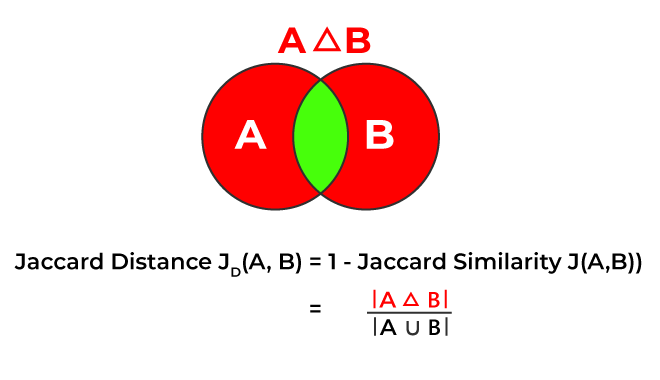

Сначала придумал, а потом нашел об этом https://www.researchgate.net/figure/Jaccard-similarity-distribution-between-questions-and-answer-containing-sentences_fig2_344372639

In [20]:
a = np.arange(5,14)
b = np.arange(10,19)
a, b

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18]))

In [21]:
A = set(a)
B = set(b)
# Intersaction and Union of two sets can also be done using & and | operators.
C = A.intersection(B)
D = A.union(B)
print('AnB = ', C)
print('AUB = ', D)
print('J(A,B) = ', float(len(C))/float(len(D)))

AnB =  {10, 11, 12, 13}
AUB =  {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
J(A,B) =  0.2857142857142857


In [15]:
from sklearn.metrics import f1_score
from copy import deepcopy
from transformers import TrainingArguments, Trainer
from transformers import TrainerCallback

#
class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            #self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train@")
            self._trainer.evaluate(eval_dataset=self._trainer.eval_dataset, metric_key_prefix="eval")
            return control_copy

def compute_metrics(pred):
    squad_preds, squad_labels = pred

    squad_preds = np.argmax(squad_preds, -1).T
    squad_labels = np.array(squad_labels).T

    # Calculate Exact Match (EM) and F1
    res = []
    f1 = []
    jac = []
    for p, l in  zip(squad_preds, squad_labels):
      if  p[0] == l[0] and p[1] == l[1]: res.append(1)
      else : res.append(0)

      # calculate f1
      f1.append(f1_score(p, l, average='macro')) #'weighted'

      # Intersaction and Union of two sets can also be done using & and | operators.
      A = set(np.arange(p[0],p[1]))
      B = set(np.arange(l[0],l[1]))
      C = A.intersection(B)
      D = A.union(B)
      if len(C) and len(D):
        jac.append(float(len(C))/float(len(D)))
      else: jac.append(0)


    em = sum(res) / len(squad_labels)
    f1 = sum(f1)/ len(squad_labels)
    jac = sum(jac)/ len(squad_labels)


    return {
        'exact_match': em,
        'f1': f1,
        'Jac': jac
    }

https://ai.stackexchange.com/questions/11900/understanding-how-the-loss-was-calculated-for-the-squad-task-in-bert-paper?newreg=e41653acccfa4269b1348d7df8e579ee

# EarlyStoppingCallback

In [24]:
from transformers import EarlyStoppingCallback, IntervalStrategy
# https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instance

training_args = TrainingArguments(trained_checkpoint,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  eval_accumulation_steps=4,
                                  logging_steps=100,
                                  save_steps=100,
                                  optim="adamw_torch",
                                  learning_rate=5e-05,
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  #save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  warmup_steps=3,
                                  lr_scheduler_type='linear',
                                  weight_decay=0.001,
                                  warmup_ratio=0.025,
                                  metric_for_best_model = 'eval_f1',
                                  gradient_accumulation_steps=4,
                                  load_best_model_at_end=True,
                                  num_train_epochs=4)

trainer = Trainer(model,
                  training_args,
                  train_dataset=train_dataset,
                  eval_dataset=validation_dataset,
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
                  )

trainer.add_callback(CustomCallback(trainer))

## EarlyStopping with F1

In [25]:
torch.cuda.empty_cache()
import os
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true' #https://discuss.huggingface.co/t/get-using-the-call-method-is-faster-warning-with-datacollatorwithpadding/23924
train_result = trainer.train()

Step,Training Loss,Validation Loss,Exact Match,F1,Jac
100,2.120700,1.931700,0.465011,0.547780,0.605165
200,1.932400,1.794503,0.470655,0.551919,0.615550
300,1.937300,1.775124,0.478555,0.560008,0.629256
400,1.924600,1.782874,0.455982,0.541573,0.602013
500,1.828700,1.725374,0.472348,0.552859,0.617607
600,1.732100,1.849105,0.466704,0.552671,0.622173


In [26]:
test_dataset = DATASETS["test"].map(
    preprocess_examples,
    batched=True,
)
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="eval")

Map:   0%|          | 0/443 [00:00<?, ? examples/s]

{'eval_loss': 1.8184661865234375,
 'eval_exact_match': 0.49435665914221216,
 'eval_f1': 0.5756207674943575,
 'eval_Jac': 0.6417737160856202,
 'eval_runtime': 37.3003,
 'eval_samples_per_second': 11.877,
 'eval_steps_per_second': 2.976,
 'epoch': 1.06}

## EarlyStopping with Jaccard

In [27]:
from transformers import EarlyStoppingCallback, IntervalStrategy
# https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instance

training_args = TrainingArguments(trained_checkpoint,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  eval_accumulation_steps=4,
                                  logging_steps=100,
                                  save_steps=100,
                                  optim="adamw_torch",
                                  learning_rate=5e-05,
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  #save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  warmup_steps=3,
                                  lr_scheduler_type='linear',
                                  weight_decay=0.001,
                                  warmup_ratio=0.025,
                                  metric_for_best_model = 'eval_Jac',
                                  gradient_accumulation_steps=4,
                                  load_best_model_at_end=True,
                                  num_train_epochs=4)

trainer = Trainer(model,
                  training_args,
                  train_dataset=train_dataset,
                  eval_dataset=validation_dataset,
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
                  )

trainer.add_callback(CustomCallback(trainer))

In [28]:
torch.cuda.empty_cache()
import os
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true' #https://discuss.huggingface.co/t/get-using-the-call-method-is-faster-warning-with-datacollatorwithpadding/23924
train_result = trainer.train()

Step,Training Loss,Validation Loss,Exact Match,F1,Jac
100,1.391500,2.046305,0.467269,0.550038,0.608764
200,1.287300,2.018388,0.456546,0.543454,0.613880
300,1.444400,1.938364,0.433409,0.524266,0.585151
400,1.958700,1.754316,0.459932,0.547780,0.609563
500,1.866600,1.766858,0.462190,0.544582,0.613909
600,1.702900,1.933191,0.456546,0.546087,0.601182
700,1.393100,1.714223,0.475169,0.559443,0.620463
800,1.354000,1.783800,0.465011,0.550790,0.611092
900,1.394000,1.717975,0.473476,0.558126,0.623940
1000,1.416800,1.775959,0.426637,0.530286,0.586025


In [29]:
test_dataset = DATASETS["test"].map(
    preprocess_examples,
    batched=True,
)
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="eval")

{'eval_loss': 1.7359944581985474,
 'eval_exact_match': 0.5079006772009029,
 'eval_f1': 0.5846501128668178,
 'eval_Jac': 0.6490334984145509,
 'eval_runtime': 36.732,
 'eval_samples_per_second': 12.06,
 'eval_steps_per_second': 3.022,
 'epoch': 2.47}

# Use custom loss in Trainer

In [28]:
# https://ai.stackexchange.com/questions/11900/understanding-how-the-loss-was-calculated-for-the-squad-task-in-bert-paper?newreg=e41653acccfa4269b1348d7df8e579ee

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=True):

        def compute_loss_qa(logits, positions, seq_length):
            one_hot_positions = torch.nn.functional.one_hot(positions, num_classes=seq_length).float()
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            loss = -torch.mean(torch.sum(one_hot_positions * log_probs, dim=-1))
            return loss

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        start_positions = inputs['start_positions']
        end_positions = inputs['end_positions']

        result = model(input_ids = input_ids,
                        attention_mask = attention_mask,
                        start_positions = start_positions,
                        end_positions = end_positions,
                        return_dict=True
                       )

        start_logits = result.start_logits
        end_logits = result.end_logits

        #print('result.loss', result.loss)


        start_loss = compute_loss_qa(start_logits, start_positions, max_seq_length)
        end_loss = compute_loss_qa(end_logits, end_positions, max_seq_length)

        total_loss = (start_loss + end_loss) / 2.0
       # print('total_loss', total_loss)


        return total_loss



In [29]:
from transformers import EarlyStoppingCallback, IntervalStrategy
# https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instance

training_args = TrainingArguments(trained_checkpoint,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  eval_accumulation_steps=4,
                                  logging_steps=100,
                                  save_steps=100,
                                  optim="adamw_torch",
                                  learning_rate=5e-05,
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  #save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  warmup_steps=3,
                                  lr_scheduler_type='linear',
                                  weight_decay=0.001,
                                  warmup_ratio=0.025,
                                  metric_for_best_model = 'eval_Jac',
                                  gradient_accumulation_steps=4,
                                  load_best_model_at_end=True,
                                  num_train_epochs=4)

trainer = CustomTrainer(model,
                  training_args,
                  train_dataset=train_dataset,
                  eval_dataset=validation_dataset,
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
                  )

trainer.add_callback(CustomCallback(trainer))

Видно, что кастом лосс считает тоже лосс, что и в самой модели

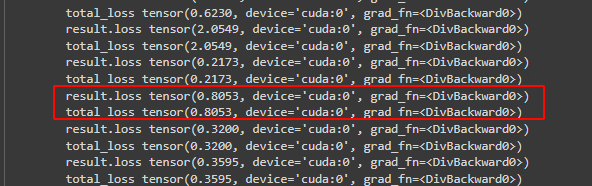

Эту проблему прошел

In [ ]:
torch.cuda.empty_cache()
import os
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true' #https://discuss.huggingface.co/t/get-using-the-call-method-is-faster-warning-with-datacollatorwithpadding/23924
train_result = trainer.train()

result.loss tensor(2.9730, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(2.9730, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(2.7431, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(2.7431, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(0.7719, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(0.7719, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(2.1957, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(2.1957, device='cuda:0', grad_fn=<DivBackward0>)


Step,Training Loss,Validation Loss


result.loss tensor(2.7003, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(2.7003, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(2.2471, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(2.2471, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(0.8033, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(0.8033, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(1.5055, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(1.5055, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(3.5241, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(3.5241, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(2.3652, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(2.3652, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(4.2549, device='cuda:0', grad_fn=<DivBackward0>)
total_loss tensor(4.2549, device='cuda:0', grad_fn=<DivBackward0>)
result.loss tensor(1.7490, device='cuda:0', grad_fn=<Di

TypeError: ignored

Но, наткнулся еще на проблему, видимо с нулевыми тензорами, которые нужно обходить отдельно.

In [30]:
torch.cuda.empty_cache()
import os
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true' #https://discuss.huggingface.co/t/get-using-the-call-method-is-faster-warning-with-datacollatorwithpadding/23924
train_result = trainer.train()

Step,Training Loss,Validation Loss


TypeError: ignored

Тут еще нужно разбираться !!!

Но уже смог пройти немного глубже в классы